Lab 11: Variational Autoencoder on MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import kagglehub
path = kagglehub.dataset_download("arnavsharma45/mnist-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mnist-dataset' dataset.
Path to dataset files: /kaggle/input/mnist-dataset


Dataset Preparation

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

Define VAE Model

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, latent_dim)   # Mean (μ)
        self.fc22 = nn.Linear(400, latent_dim)   # Log variance (logσ²)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)  # μ and logσ²

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # z = μ + σ * ε

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

Loss Function

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

Initialize Model & Optimizer

In [ ]:
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 20
train_losses, psnr_history, ssim_history = [], [], []

Training & Metric Evaluation per Epoch

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    model.eval()
    mse_list, psnr_list, ssim_list = [], [], []
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            x_orig = data.cpu().numpy()
            x_recon = recon_batch.view(-1, 1, 28, 28).cpu().numpy()

            for i in range(len(x_orig)):
                orig = x_orig[i, 0]
                rec = x_recon[i, 0]
                mse_val = np.mean((orig - rec) ** 2)
                mse_list.append(mse_val)
                psnr_list.append(psnr(orig, rec, data_range=1))
                ssim_list.append(ssim(orig, rec, data_range=1))

    psnr_history.append(np.mean(psnr_list))
    ssim_history.append(np.mean(ssim_list))

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_train_loss:.4f} | "
          f"PSNR: {np.mean(psnr_list):.3f} | SSIM: {np.mean(ssim_list):.3f}")

Epoch [1/20] | Loss: 49.2570 | PSNR: 13.347 | SSIM: 0.381
Epoch [2/20] | Loss: 42.5184 | PSNR: 13.565 | SSIM: 0.403
Epoch [3/20] | Loss: 41.4425 | PSNR: 13.672 | SSIM: 0.422
Epoch [4/20] | Loss: 40.7862 | PSNR: 13.771 | SSIM: 0.441
Epoch [5/20] | Loss: 40.3012 | PSNR: 13.864 | SSIM: 0.449
Epoch [6/20] | Loss: 39.9422 | PSNR: 13.836 | SSIM: 0.451
Epoch [7/20] | Loss: 39.6417 | PSNR: 13.935 | SSIM: 0.465
Epoch [8/20] | Loss: 39.4002 | PSNR: 13.942 | SSIM: 0.465
Epoch [9/20] | Loss: 39.1871 | PSNR: 13.978 | SSIM: 0.473
Epoch [10/20] | Loss: 39.0195 | PSNR: 14.015 | SSIM: 0.474
Epoch [11/20] | Loss: 38.8723 | PSNR: 14.014 | SSIM: 0.479
Epoch [12/20] | Loss: 38.7233 | PSNR: 14.031 | SSIM: 0.477
Epoch [13/20] | Loss: 38.6062 | PSNR: 14.093 | SSIM: 0.487
Epoch [14/20] | Loss: 38.4940 | PSNR: 14.084 | SSIM: 0.485
Epoch [15/20] | Loss: 38.3804 | PSNR: 14.108 | SSIM: 0.489
Epoch [16/20] | Loss: 38.2775 | PSNR: 14.130 | SSIM: 0.490
Epoch [17/20] | Loss: 38.2031 | PSNR: 14.103 | SSIM: 0.489
Epoch 

Evaluation

In [ ]:
print("\n📊 Final Evaluation:")
print(f"Average Training Loss: {np.mean(train_losses):.4f}")
print(f"Final PSNR: {psnr_history[-1]:.3f}")
print(f"Final SSIM: {ssim_history[-1]:.3f}")


📊 Final Evaluation:
Average Training Loss: 39.7563
Final PSNR: 14.172
Final SSIM: 0.499


 Visualizations

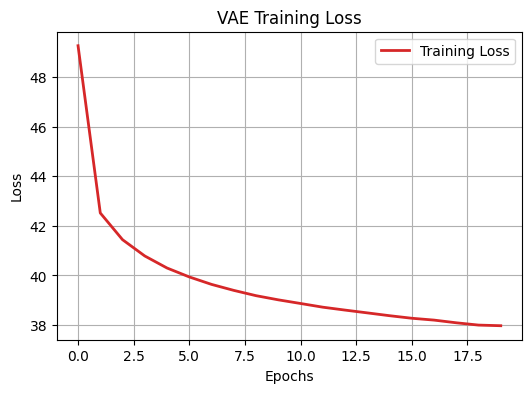

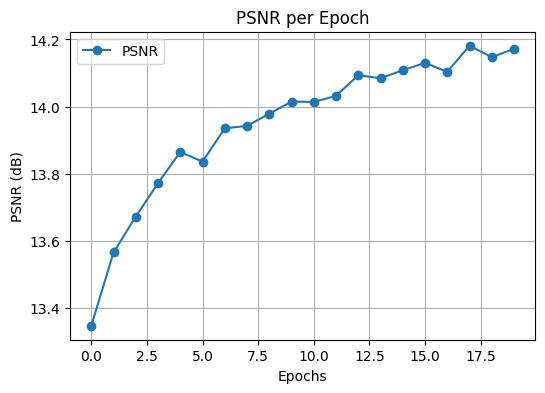

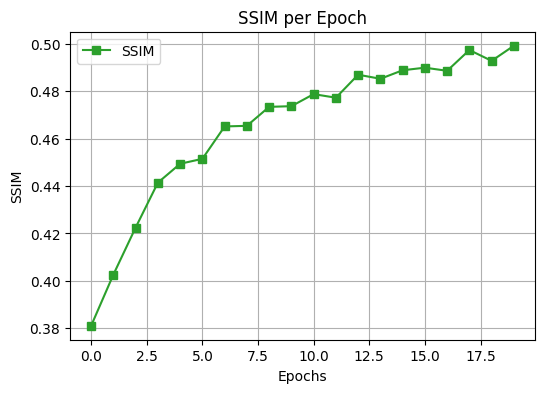

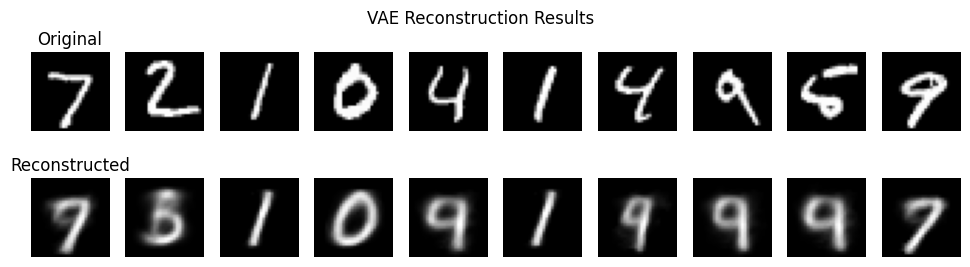

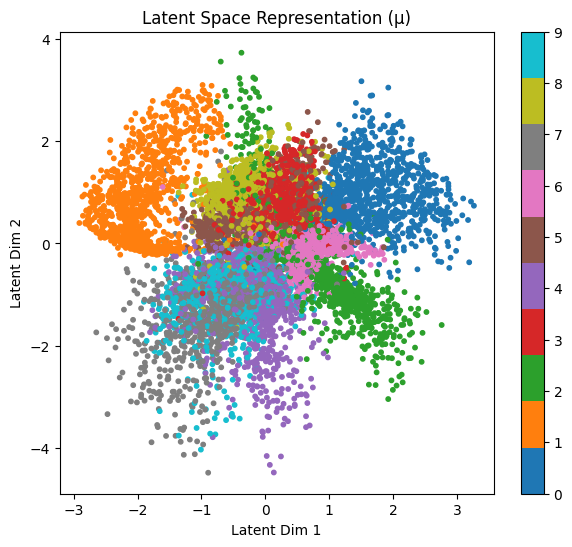

In [ ]:
# (a) Loss Curve
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Training Loss", color='tab:red', linewidth=2)
plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.legend(); plt.grid(True)
plt.show()

# (b) PSNR Curve
plt.figure(figsize=(6,4))
plt.plot(psnr_history, label="PSNR", color='tab:blue', marker='o')
plt.xlabel("Epochs"); plt.ylabel("PSNR (dB)")
plt.title("PSNR per Epoch")
plt.legend(); plt.grid(True)
plt.show()

# (c) SSIM Curve
plt.figure(figsize=(6,4))
plt.plot(ssim_history, label="SSIM", color='tab:green', marker='s')
plt.xlabel("Epochs"); plt.ylabel("SSIM")
plt.title("SSIM per Epoch")
plt.legend(); plt.grid(True)
plt.show()

# (d) Reconstruction Visualization
test_iter = iter(test_loader)
test_imgs, _ = next(test_iter)
test_imgs = test_imgs.to(device)
reconstructed, _, _ = model(test_imgs)
reconstructed = reconstructed.view(-1, 1, 28, 28).cpu().detach()

fig, axes = plt.subplots(2, 10, figsize=(12, 3))
for i in range(10):
    axes[0, i].imshow(test_imgs[i, 0].cpu(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i, 0], cmap='gray')
    axes[1, i].axis('off')
axes[0, 0].set_title("Original")
axes[1, 0].set_title("Reconstructed")
plt.suptitle("VAE Reconstruction Results")
plt.show()

# (e) Latent Space Visualization
with torch.no_grad():
    mu_vals, labels = [], []
    for data, target in test_loader:
        data = data.to(device)
        mu, _ = model.encode(data.view(-1, 28*28))
        mu_vals.append(mu.cpu())
        labels.append(target)
mu_vals = torch.cat(mu_vals)
labels = torch.cat(labels)

plt.figure(figsize=(7,6))
plt.scatter(mu_vals[:, 0], mu_vals[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar()
plt.title("Latent Space Representation (μ)")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.show()